# Creating Dataset based on similarity

In this notebook, I am going to divide each test set/task into two separate datasets. The goal is first choose k points as support set, then compute the similarity of other points with these k points, and devide them (query) into two sepparate datasets based on the similarity with the support set. So, we will follow the following algorithm for each task task (ChEMBLID):
1. Choose the `k` points as the support set (`k` positive and `k` negative)
2. Compute the Tanimoto similarity of other points (queries) with these `k` points
3. Divide the query into two different parts based on the similarity with support set (of course this new dataset also contains the support set)

## Importing Required Libraries


In [1]:
# Setting up local details:
import os
import sys
import gzip
import json
import pickle
from typing import List, Dict, Tuple, Union, Optional

import numpy as np
import pandas as pd
from tqdm import tqdm
import torch

# This should be the location of the checkout of the FS-Mol repository:
FS_MOL_CHECKOUT_PATH = os.path.join("/data/local/apps/", "Meta-Learning", "FS-Mol")
FS_MOL_DATASET_PATH = os.path.join("/data/local/apps/", "Meta-Learning", "FS-Mol", "datasets")

os.chdir(FS_MOL_CHECKOUT_PATH)
sys.path.insert(0, FS_MOL_CHECKOUT_PATH)

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rcParams.update(
    {
        "pgf.texsystem": "pdflatex",
        "font.family": "serif",
        "font.serif": "Computer Modern Roman",
        "font.size": 24,
        "text.usetex": True,
        "pgf.rcfonts": False,
    }
)


In [3]:
FILENAME = "CHEMBL641707.jsonl.gz"
with gzip.open(os.path.join(FS_MOL_CHECKOUT_PATH, "datasets/test/", FILENAME), "r") as jf:
    data = [json.loads(line) for line in jf]

# The data is a list of dictionaries, each dictionary is a molecule:
print(len(data))

164


## Selecting Required/Relevant Tasks

In [42]:
from fs_mol.data import FSMolDataset, DataFold
dataset = FSMolDataset.from_directory(FS_MOL_DATASET_PATH, task_list_file=os.path.join(FS_MOL_DATASET_PATH, "fsmol-0.1.json"))

tasks = []
# next line will create iterable object that will iterate over all tasks in the test dataset
test_task_iterable = dataset.get_task_reading_iterable(DataFold.TEST)
for task in tqdm(iter(test_task_iterable)):
    tasks.append(task)

157it [00:11, 13.62it/s]


In [4]:
train_tasks = []
# next line will create iterable object that will iterate over all tasks in the test dataset
train_task_iterable = dataset.get_task_reading_iterable(DataFold.TRAIN)
for task in tqdm(iter(train_task_iterable)):
    train_tasks.append(task)

4938it [01:20, 61.07it/s] 


In [7]:
print(len(tasks))
print(len(train_tasks))

157
4938


In [14]:
# The number of samples in each task:
tasks_size = np.array([len(task.samples) for task in tasks])
train_tasks_size = np.array([len(task.samples) for task in train_tasks])

train_tasks_size = train_tasks_size[train_tasks_size < 512]
# The number of tasks with more than 512 samples:
np.array([task_size > 512 for task_size in tasks_size]).sum()

27

In [15]:
tasks_size.min()

130

In [16]:
train_tasks_size.shape

(4845,)

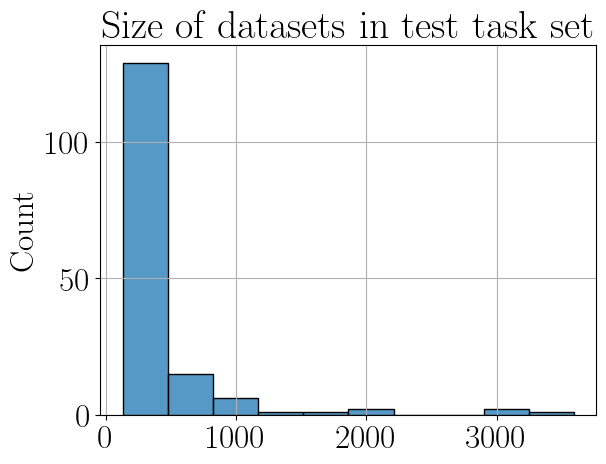

In [17]:
plt.figure()
sns.histplot(np.array(tasks_size), bins=10)
plt.title('Size of datasets in test task set') 
plt.grid()
plt.show()

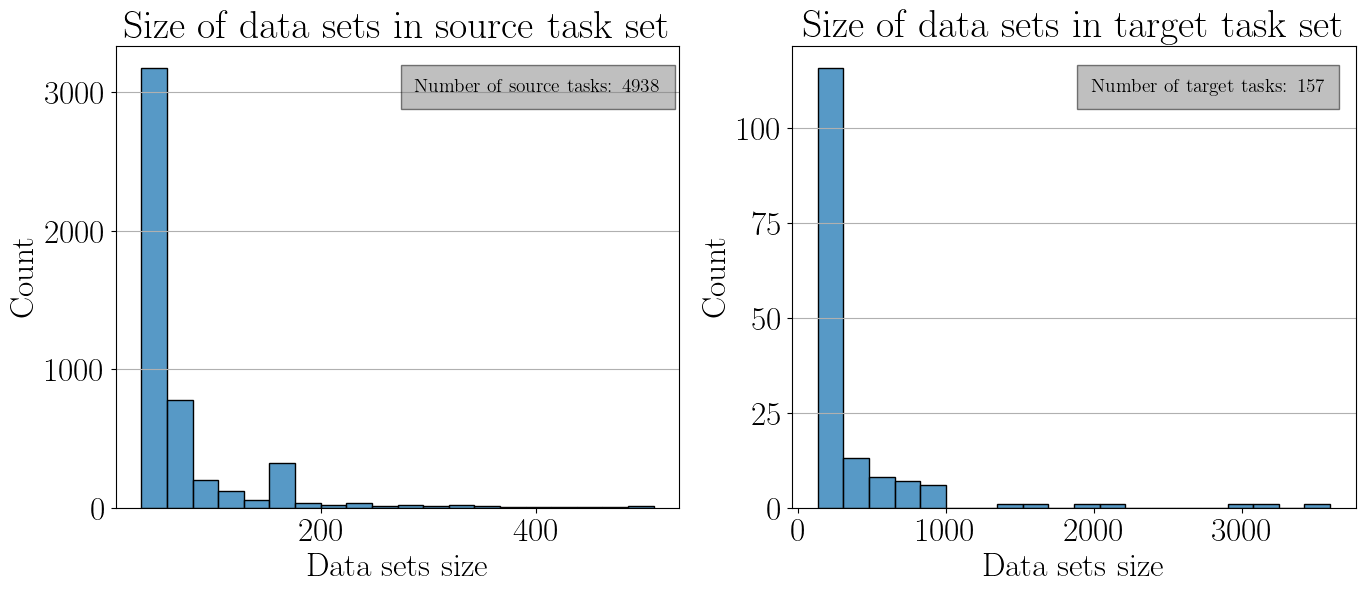

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(np.array(train_tasks_size), bins=20, ax=ax[0])
sns.histplot(np.array(tasks_size), bins=20,  ax=ax[1])
ax[0].set_title('Size of data sets in source task set') 
ax[0].set_xlabel('Data sets size')
ax[1].set_title('Size of data sets in target task set') 
ax[1].set_xlabel('Data sets size')

ax[0].text(0.53, 0.9, 'Number of source tasks: 4938', transform=ax[0].transAxes, bbox={
        'facecolor': 'grey', 'alpha': 0.5, 'pad': 10}, fontsize=14)

ax[1].text(0.53, 0.9, 'Number of target tasks: 157', transform=ax[1].transAxes, bbox={
        'facecolor': 'grey', 'alpha': 0.5, 'pad': 10}, fontsize=14)

fig.savefig('assets/dataset_size.pdf', transparent=True, backend='pgf', bbox_inches='tight')
ax[0].grid(axis='y')
ax[1].grid(axis='y')
plt.show()

In [29]:
train_proteins_path = os.path.join(FS_MOL_DATASET_PATH, "targets", "train_proteins.csv")
test_proteins_path = os.path.join(FS_MOL_DATASET_PATH, "targets", "test_proteins.csv")
target_info_path = os.path.join(FS_MOL_DATASET_PATH, "target_info.csv")

train_proteins_df = pd.read_csv(train_proteins_path)
test_proteins_df = pd.read_csv(test_proteins_path)
target_info_df = pd.read_csv(target_info_path)

In [30]:
train_chembl_id = train_proteins_df["chembl_id"].values.tolist()
test_chembl_id = test_proteins_df["chembl_id"].values.tolist()

### ChEMBL Confidence Score 
Let's first filter the dataset based on ChEMBL confidence score. We just consider the tasks with confidence score greater than 8 (which means tasks that contain just a single protein).


In [28]:
## Check how many of ChEMBL ids in train adn test set have confidence score of 8 or 9
train_proteins_df = train_proteins_df[train_proteins_df["confidence"] >= 8]
test_proteins_df = test_proteins_df[test_proteins_df["confidence"] >= 8]


print(train_proteins_df.shape)
print(test_proteins_df.shape)

NameError: name 'train_proteins_df' is not defined

In [6]:
train_proteins_df.reset_index(inplace=True, drop=True)
test_proteins_df.reset_index(inplace=True, drop=True)

### Percentage of positives: 
We also filter the dataset based on the percentage of positives. We just consider the tasks with percentage of positives between 0.3 and 0.7.

In [31]:
def extract_pos_perc(tasks: List) -> np.ndarray:
    pos_perc = []
    for task in tasks:
        pos_perc.append(target_info_df[target_info_df['chembl_id'] == task]['percentage_pos'].values[0])
    
    return np.array(pos_perc)

In [27]:
a = extract_pos_perc(train_proteins_df.chembl_id.values.tolist())
b = extract_pos_perc(test_proteins_df.chembl_id.values.tolist())

train_proteins_df = train_proteins_df[(a >= 30) & (a <= 70)]
test_proteins_df = test_proteins_df[(b >= 30) & (b <= 70)]

print(train_proteins_df.shape)
print(test_proteins_df.shape)

NameError: name 'train_proteins_df' is not defined

In [ ]:
fig = plt.figure(figsize=(10, 6))
plt.plot(actives_size, 'o')
plt.title('Percentage of actives in each target tasks')
plt.xlabel('Target task ID')
plt.ylabel('Percentage of active moleulces') 
plt.grid()

#fig.savefig('assets/perc_active.svg', format='svg')
plt.show()

### EC super class Available: 
We also filter the dataset based on the availability of EC super class. We just consider the tasks with EC super class available.

In [7]:
def extract_EC_super_Class(tasks: List) -> np.ndarray:
    super_class = []
    for task in tasks:
        super_class.append(target_info_df[target_info_df['chembl_id'] == task]['EC_super_class'].values[0])
    
    return np.array(super_class)

In [8]:
a = extract_EC_super_Class(train_proteins_df.chembl_id.values.tolist())
b = extract_EC_super_Class(test_proteins_df.chembl_id.values.tolist())

In [9]:
EC_super_class_dict = {'1':'oxidoreductase',
                       "2":'transferase',
                       "3":'hydrolase',
                       "4":'lyase',
                       "5":'isomerase',
                       "6":'ligase',
                       "7":'translocase'}

In [10]:
train_proteins_df = train_proteins_df[np.isin(a, np.array(['1', '2', '3', '4', '5', '6', '7']))]
test_proteins_df = test_proteins_df[np.isin(b, np.array(['1', '2', '3', '4', '5', '6', '7']))]

print(train_proteins_df.shape)
print(test_proteins_df.shape)

(2684, 19)
(157, 19)


In [11]:
train_EC = np.array([EC_super_class_dict[item] for item in extract_EC_super_Class(train_proteins_df.chembl_id.values.tolist())])
test_EC = np.array([EC_super_class_dict[item] for item in extract_EC_super_Class(test_proteins_df.chembl_id.values.tolist())])

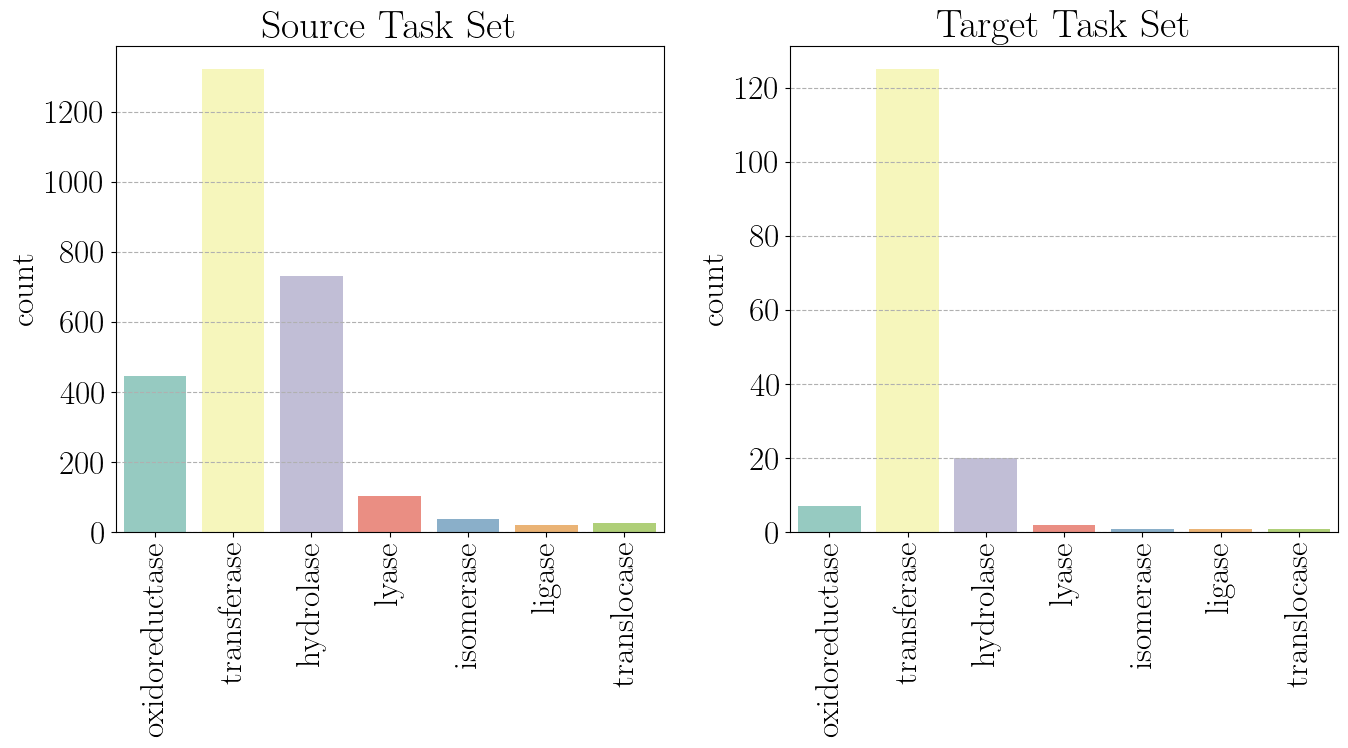

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(14, 8))
sns.countplot(x=train_EC, palette="Set3", ax=ax[0], order=['oxidoreductase', 'transferase', 'hydrolase', 'lyase', 'isomerase', 'ligase', 'translocase'])
sns.countplot(x=test_EC, palette="Set3", ax=ax[1], order=['oxidoreductase', 'transferase', 'hydrolase', 'lyase', 'isomerase', 'ligase', 'translocase'])
ax[0].set_xticklabels(['oxidoreductase', 'transferase', 'hydrolase', 'lyase', 'isomerase', 'ligase', 'translocase'], rotation=90)
ax[0].set_title('Source Task Set')
#ax[0].set_xlabel('Protein EC super class')
ax[0].grid(axis='y', linestyle='--')

ax[1].set_xticklabels(['oxidoreductase', 'transferase', 'hydrolase', 'lyase', 'isomerase', 'ligase', 'translocase'], rotation=90)
ax[1].set_title('Target Task Set')
ax[1].grid(axis='y', linestyle='--')

fig.tight_layout()
fig.savefig('assets/task_composition.pdf', transparent=True, backend='pgf', bbox_inches='tight')

plt.show()

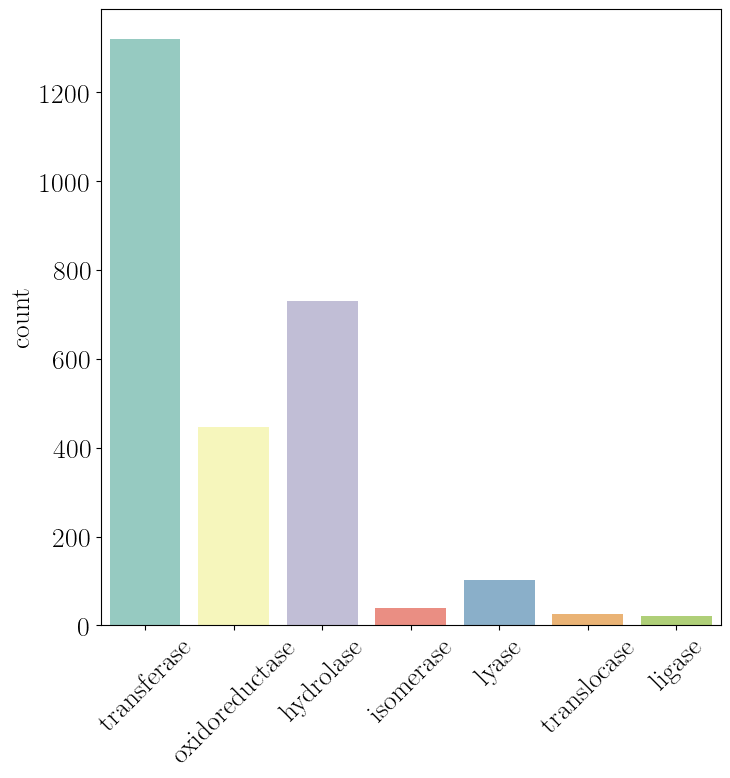

In [144]:
plt.figure(figsize=(8, 8))
sns.countplot(x=train_EC, palette="Set3")
plt.xticks(rotation=45)
plt.show()

### Filter based on size:
We also filter the dataset based on the size of the dataset. We just consider the tasks with size greater than 156 and less than 1024.

In [145]:
def filter_size(tasks: List) -> np.ndarray:
    cleaned_size = []
    for task in tasks:
        cleaned_size.append(target_info_df[target_info_df['chembl_id'] == task]['cleaned_size'].values[0])
    
    return np.array(cleaned_size)

In [146]:
a = filter_size(train_proteins_df.chembl_id.values.tolist())
b = filter_size(test_proteins_df.chembl_id.values.tolist())

In [147]:
train_proteins_df = train_proteins_df[(a >= 100) & (a <= 1024)]
test_proteins_df = test_proteins_df[(b >= 100) & (b <= 1024)]

print(train_proteins_df.shape)
print(test_proteins_df.shape)

(497, 19)
(150, 19)


### Filter based on organism: 
We also filter the dataset based on the organism of the protein. We just consider the tasks with organism equal to `Homo sapiens`.

In [148]:
def filter_organism(tasks: List) -> np.ndarray:
    organism = []
    for task in tasks:
        organism.append(target_info_df[target_info_df['chembl_id'] == task]['assay_organism'].values[0])
    
    return np.array(organism)

In [149]:
a = filter_organism(train_proteins_df.chembl_id.values.tolist())
b = filter_organism(test_proteins_df.chembl_id.values.tolist())

In [150]:
train_proteins_df = train_proteins_df[(a == 'Homo sapiens')]
test_proteins_df = test_proteins_df[(b == 'Homo sapiens')]

print(train_proteins_df.shape)
print(test_proteins_df.shape)

(366, 19)
(100, 19)


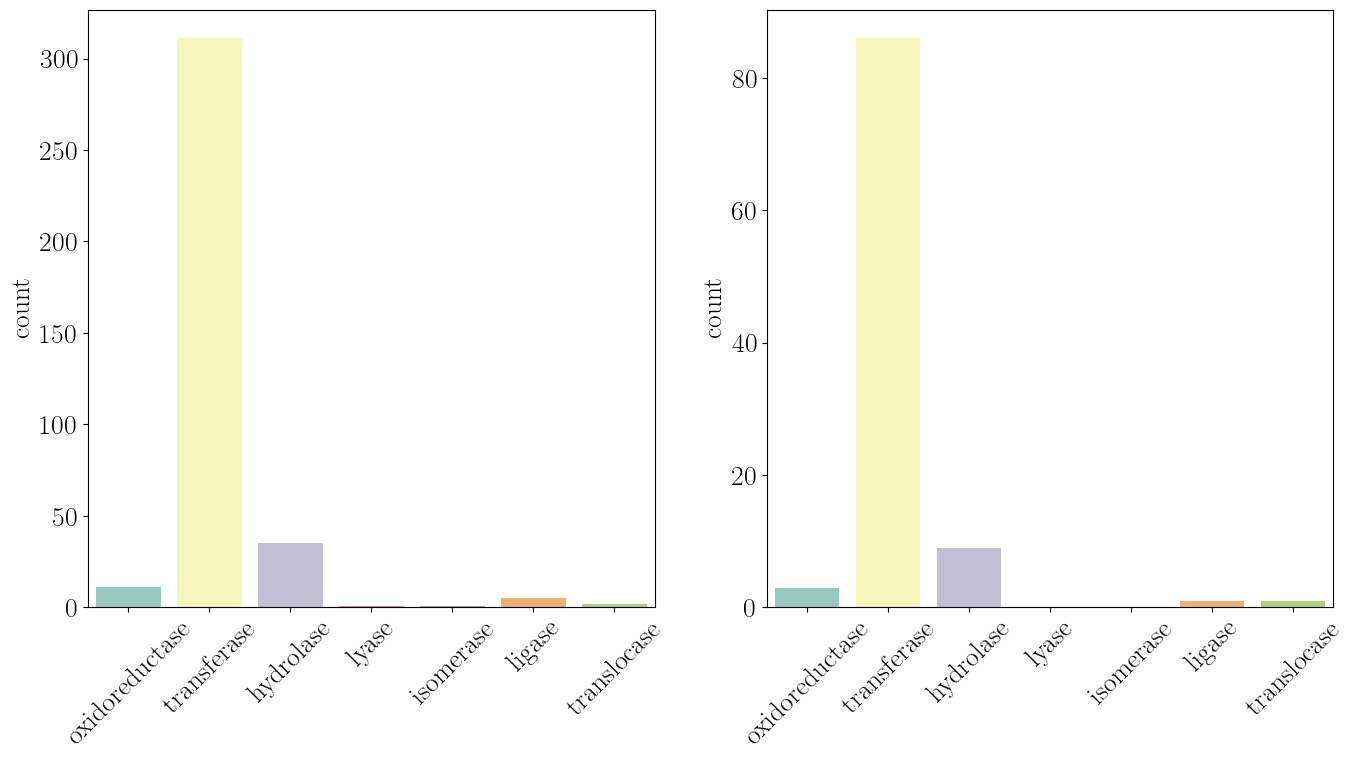

In [151]:
train_EC = np.array([EC_super_class_dict[item] for item in extract_EC_super_Class(train_proteins_df.chembl_id.values.tolist())])
test_EC = np.array([EC_super_class_dict[item] for item in extract_EC_super_Class(test_proteins_df.chembl_id.values.tolist())])

fig, ax = plt.subplots(1, 2, figsize=(14, 8))
sns.countplot(x=train_EC, palette="Set3", ax=ax[0], order=['oxidoreductase', 'transferase', 'hydrolase', 'lyase', 'isomerase', 'ligase', 'translocase'])
sns.countplot(x=test_EC, palette="Set3", ax=ax[1], order=['oxidoreductase', 'transferase', 'hydrolase', 'lyase', 'isomerase', 'ligase', 'translocase'])
ax[0].set_xticklabels(['oxidoreductase', 'transferase', 'hydrolase', 'lyase', 'isomerase', 'ligase', 'translocase'], rotation=45)
ax[1].set_xticklabels(['oxidoreductase', 'transferase', 'hydrolase', 'lyase', 'isomerase', 'ligase', 'translocase'], rotation=45)

fig.tight_layout()
plt.show()

## Distance Analysis

In [26]:
def select_training_assays(training_lookup: Dict, distance_dict: Dict) -> Tuple:
    distance = []
    train_assays = []
    for i, assay in enumerate(distance_dict['train_chembl_ids']):
        if assay in training_lookup['train']:
            distance.append(distance_dict['distance_matrices'][i])
            train_assays.append(assay)

    d_mat = torch.stack(distance, dim=0)
    return d_mat, train_assays

In [27]:
import pickle
import json
with open('datasets/fsmol-0.1.json', 'r') as f:
    fsmol_original_lookup = json.load(f)
fsmol_lookup = {'train': train_proteins_df.chembl_id.values.tolist(), 'test': test_proteins_df.chembl_id.values.tolist()}
## Reading Distance Matrices (which contain distance and train and test chembl ids)
with open('./datasets/test/hardness/otdd_Roberta-Zinc480M-102M.pkl', 'rb') as f:
    fsmol_distance_matrices = pickle.load(f)

In [28]:
d_mat, train_assays = select_training_assays(fsmol_lookup_v3, fsmol_distance_matrices)

In [29]:
def select_test_assay(chembl_id: str, distance_mat: torch.Tensor, distance_dict: Dict) -> torch.Tensor:
    for i, assay in enumerate(distance_dict['test_chembl_ids']):
        if assay == chembl_id:
            test_id = i
            break
    
    x = distance_mat[:, test_id]
    return x

In [60]:
chembl_id = 'CHEMBL1963773'
test_dist= select_test_assay(chembl_id, d_mat, fsmol_distance_matrices)

In [61]:
fsmol_lookup_v3['test']

['CHEMBL1119333',
 'CHEMBL1243967',
 'CHEMBL1243970',
 'CHEMBL1614292',
 'CHEMBL1614433',
 'CHEMBL1737951',
 'CHEMBL1738573',
 'CHEMBL1794324',
 'CHEMBL1794504',
 'CHEMBL1794519',
 'CHEMBL1794557',
 'CHEMBL1963701',
 'CHEMBL1963705',
 'CHEMBL1963721',
 'CHEMBL1963731',
 'CHEMBL1963756',
 'CHEMBL1963773',
 'CHEMBL1963810',
 'CHEMBL1963818',
 'CHEMBL1963824',
 'CHEMBL1963827',
 'CHEMBL1963831',
 'CHEMBL1963838',
 'CHEMBL1963910',
 'CHEMBL1963969',
 'CHEMBL1964005',
 'CHEMBL1964101',
 'CHEMBL1964106',
 'CHEMBL1964115',
 'CHEMBL2354305',
 'CHEMBL3214944',
 'CHEMBL3705469',
 'CHEMBL3707783',
 'CHEMBL3887295',
 'CHEMBL3887334',
 'CHEMBL3887759',
 'CHEMBL3888181',
 'CHEMBL3888461',
 'CHEMBL657032',
 'CHEMBL663407',
 'CHEMBL819742',
 'CHEMBL924949',
 'CHEMBL1006005',
 'CHEMBL1066254',
 'CHEMBL1613777',
 'CHEMBL1613800',
 'CHEMBL1613898',
 'CHEMBL1613907',
 'CHEMBL1613926',
 'CHEMBL1613949',
 'CHEMBL1614153',
 'CHEMBL1614423',
 'CHEMBL1614466',
 'CHEMBL1614508',
 'CHEMBL1614522',
 'CHEMBL173807

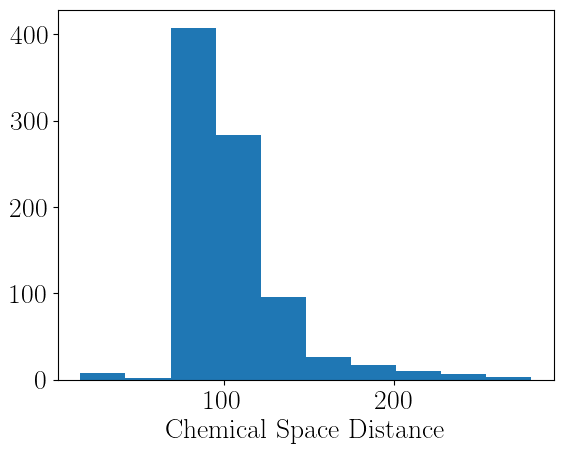

In [62]:
plt.hist(test_dist)
plt.xlabel('Chemical Space Distance')
plt.show()

## Filter data based on clustering sequence

In [116]:
seq_train_df = pd.read_csv('./datasets/targets/mmseqs2/train_v2_cluster.tsv', sep='\t', header=None)
seq_test_df = pd.read_csv('./datasets/targets/mmseqs2/test_v2_cluster.tsv', sep='\t', header=None)

seq_train_df.columns = ['repr', 'seq']
seq_test_df.columns = ['repr',  'seq']

print(seq_train_df.shape)
print(seq_test_df.shape)

print(seq_train_df['repr'].unique().shape)
print(seq_test_df['repr'].unique().shape)

(1411, 2)
(157, 2)
(861,)
(117,)


In [117]:
train_uniprot = seq_train_df['repr'].apply(lambda x: x.split('|')[1]).tolist()
test_uniprot = seq_test_df['repr'].tolist()

In [118]:
## Keep the unique uniprot ids
train_uniprot = set(train_uniprot)
test_uniprot = set(test_uniprot)

In [119]:
test_uniprot.__len__()

117

In [120]:
a = []
b = []
for i, item in enumerate(test_proteins_df['target_accession_id'].values.tolist()):
    if item in test_uniprot:
        a.append(test_proteins_df['chembl_id'][i])
        test_uniprot.remove(item)



for i, item in enumerate(train_proteins_df['target_accession_id'].values.tolist()):
    if item in train_uniprot:
        b.append(train_proteins_df['chembl_id'][i])
        train_uniprot.remove(item)


In [122]:
len(b)

806

In [123]:
fsmol_lookup_v3 = {'train': b, 'test': a}

In [125]:
with open('datasets/fsmol-0.3.json', 'w') as f:
    json.dump(fsmol_lookup_v3, f)

In [49]:
fsmol_lookup_v3['train'].__len__()

861

In [13]:
a_EC = extract_EC_super_Class(a)
b_EC = extract_EC_super_Class(b)

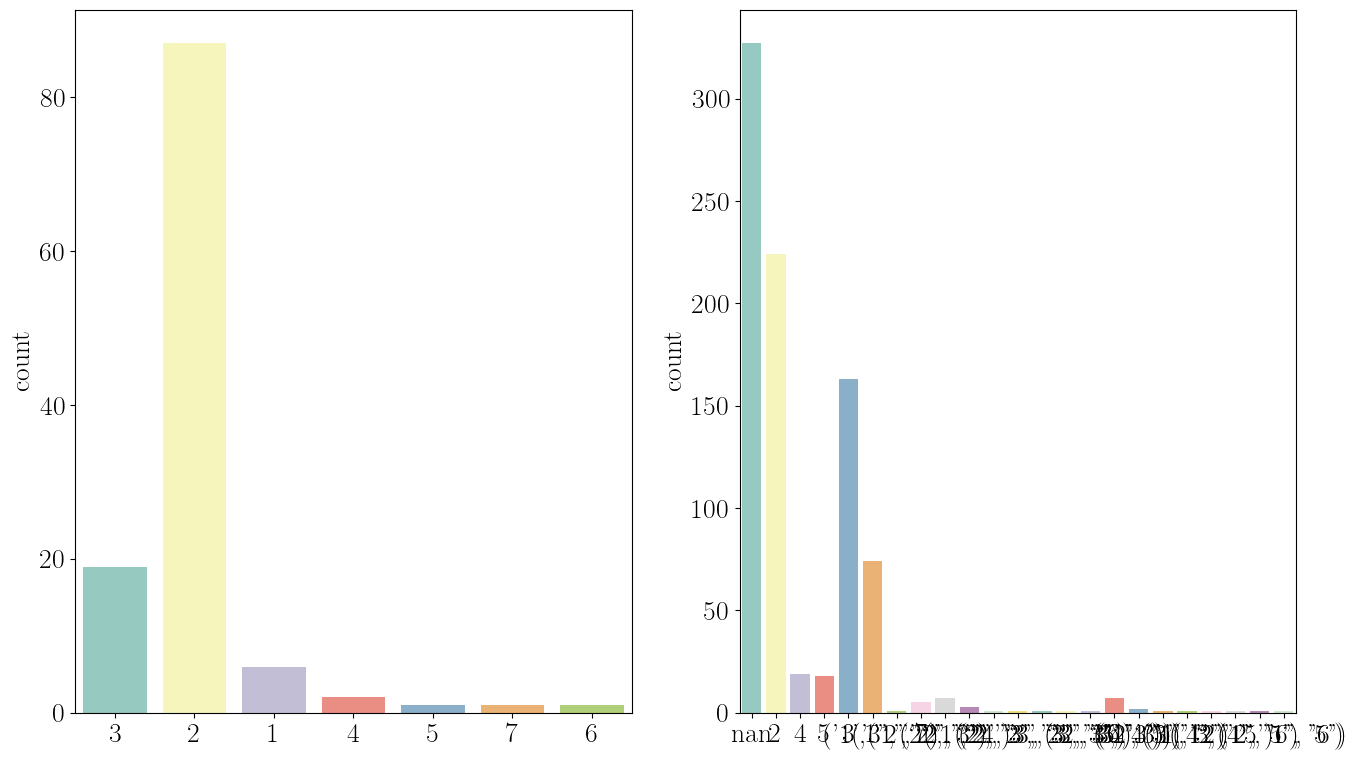

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(14, 8))
sns.countplot(x=a_EC, palette="Set3", ax=ax[0])
sns.countplot(x=b_EC, palette="Set3", ax=ax[1])

fig.tight_layout()
plt.show()

## Other Analysis

In [39]:
# The number of actives in each task:
tasks_name  = [task.name for task in tasks]
actives = []
actives_size = []
for task in tasks:
    dummy = []
    for sample in task.samples:
        dummy.append(sample.bool_label)

    actives.append(np.array(dummy))
    actives_size.append(np.array(dummy).sum()/len(dummy))

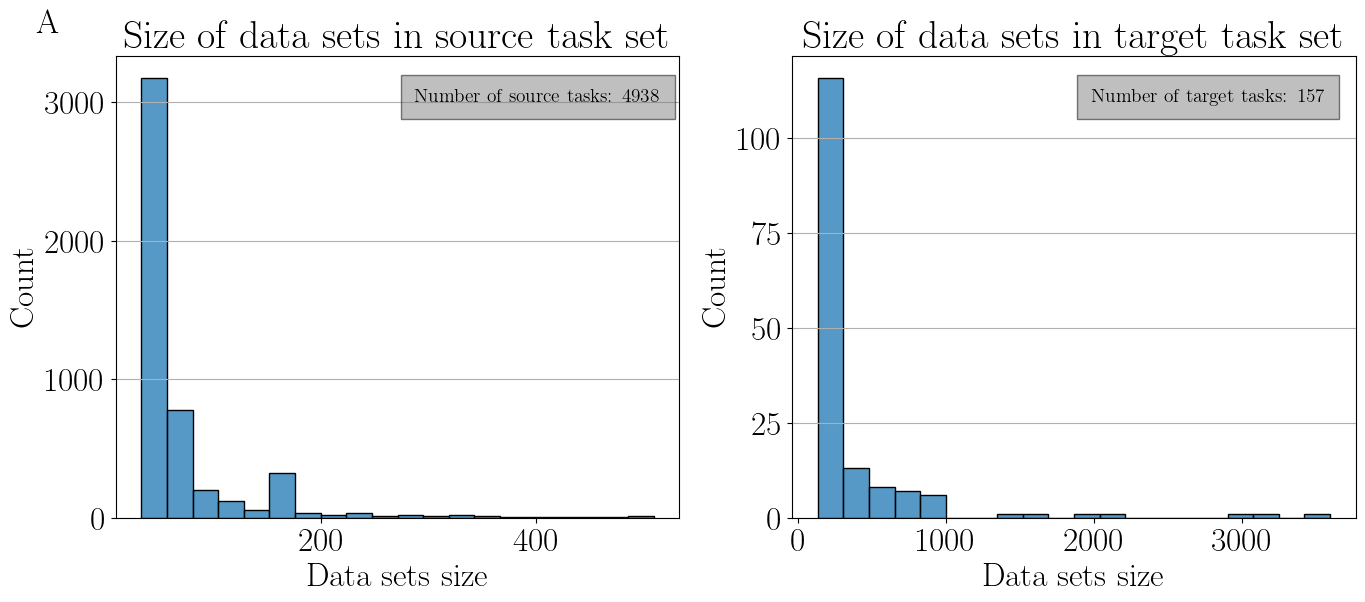

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(np.array(train_tasks_size), bins=20, ax=ax[0])
sns.histplot(np.array(tasks_size), bins=20,  ax=ax[1])
ax[0].set_title('Size of data sets in source task set') 
ax[0].set_xlabel('Data sets size')
ax[1].set_title('Size of data sets in target task set') 
ax[1].set_xlabel('Data sets size')

ax[0].text(0.53, 0.9, 'Number of source tasks: 4938', transform=ax[0].transAxes, bbox={
        'facecolor': 'grey', 'alpha': 0.5, 'pad': 10}, fontsize=14)

ax[1].text(0.53, 0.9, 'Number of target tasks: 157', transform=ax[1].transAxes, bbox={
        'facecolor': 'grey', 'alpha': 0.5, 'pad': 10}, fontsize=14)

fig.savefig('assets/dataset_size.pdf', transparent=True, backend='pgf', bbox_inches='tight')
ax[0].text(-0.1, 1.1, 'A', transform=ax[0].transAxes,
      fontsize=24, fontweight='bold', va='top', ha='right')
ax[0].grid(axis='y')
ax[1].grid(axis='y')
plt.show()

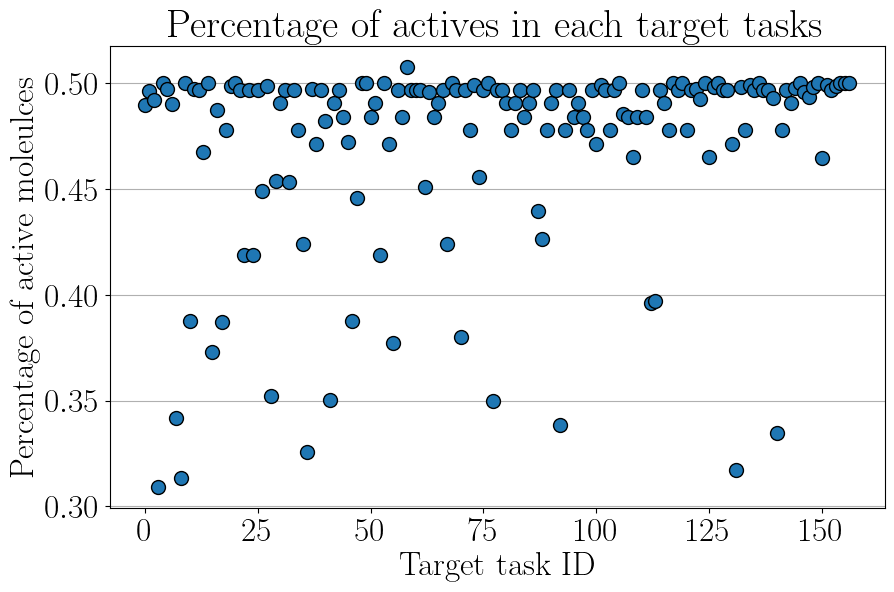

In [53]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(actives_size, 'o', markersize=10, markeredgecolor='black')
plt.title('Percentage of actives in each target tasks')
plt.xlabel('Target task ID')
plt.ylabel('Percentage of active moleulces') 
plt.grid(axis='y')
#ax.set_xticklabels(tasks_name, rotation=90, ha='right', fontdict={'fontsize': 12})

#fig.savefig('assets/perc_active.svg', format='svg')
plt.show()


<BarContainer object of 157 artists>

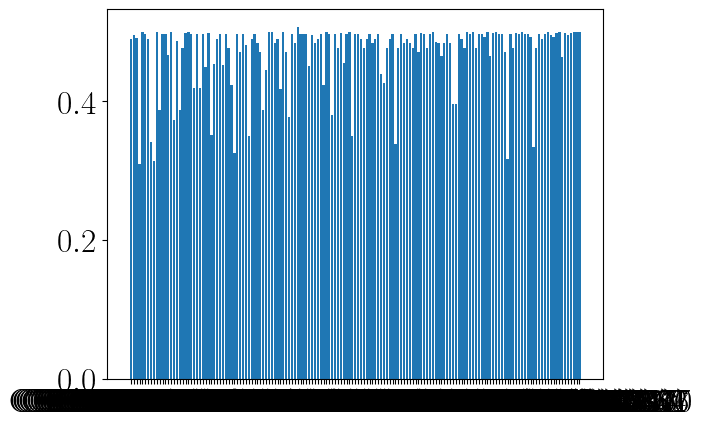

In [45]:
#plt.bar(tasks_name, actives_size)

In [12]:
from fs_mol.data import StratifiedTaskSampler
task_sampler = StratifiedTaskSampler(
    train_size_or_ratio = 16,
    valid_size_or_ratio = 0.0,
    test_size_or_ratio = 512, 
    allow_smaller_test = True
)

In [13]:
tasks_sample = [task_sampler.sample(task, seed=0) for task in tasks]

train_size: List = [len(task_sample.train_samples) for task_sample in tasks_sample]
test_size: List = [len(task_sample.test_samples) for task_sample in tasks_sample]



"""print(f"Number of samples in task: {len(task.samples)}")
print(f"Number of train samples: {len(task_sample.train_samples)}")
print(f"Number of test samples: {len(task_sample.test_samples)}")
print(f"Number of valid samples: {len(task_sample.valid_samples)}")"""

'print(f"Number of samples in task: {len(task.samples)}")\nprint(f"Number of train samples: {len(task_sample.train_samples)}")\nprint(f"Number of test samples: {len(task_sample.test_samples)}")\nprint(f"Number of valid samples: {len(task_sample.valid_samples)}")'

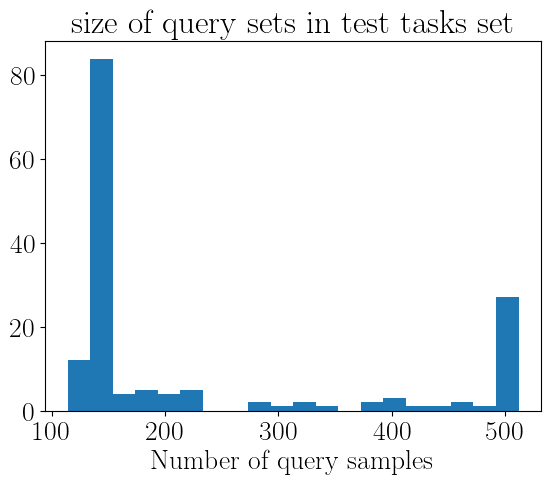

In [16]:
plt.hist(test_size, bins=20)
plt.title('size of query sets in test tasks set')
plt.xlabel('Number of query samples')
plt.show()

In [17]:
print(np.array(test_size).min())
print(np.array(test_size).max())
print(np.array(test_size).mean())

114
512
234.47770700636943


In [65]:
""" print(f'number of actives in Support set: {sum([mol.bool_label for mol in task_sample.train_samples])}')
print(f'percentage of actives in Support set: {sum([mol.bool_label for mol in task_sample.train_samples])/len(task_sample.train_samples)}')

print(f'number of actives in Query set: {sum([mol.bool_label for mol in task_sample.test_samples])}')
print(f'percentage of actives in Query set: {sum([mol.bool_label for mol in task_sample.test_samples])/len(task_sample.test_samples)}') """

" print(f'number of actives in Support set: {sum([mol.bool_label for mol in task_sample.train_samples])}')\nprint(f'percentage of actives in Support set: {sum([mol.bool_label for mol in task_sample.train_samples])/len(task_sample.train_samples)}')\n\nprint(f'number of actives in Query set: {sum([mol.bool_label for mol in task_sample.test_samples])}')\nprint(f'percentage of actives in Query set: {sum([mol.bool_label for mol in task_sample.test_samples])/len(task_sample.test_samples)}') "

In [18]:
from rdkit import Chem,DataStructs
import numpy as np
from collections import defaultdict
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
import rdkit
print(rdkit.__version__)

2022.03.2


In [19]:
sims_tasks: List[np.ndarray] = []
for task_sample in tasks_sample:
    sims = []
    for supp_mol in task_sample.train_samples:
        mol1 = Chem.MolFromSmiles(supp_mol.smiles)
        sim = []
        fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 2, 2048) 

        for query_mol in task_sample.test_samples:
            mol2 = Chem.MolFromSmiles(query_mol.smiles)
            fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 2, 2048)
            sim.append(DataStructs.TanimotoSimilarity(fp1,fp2))
        
        sims.append(sim)
    sims_tasks.append(np.array(sims))

In [20]:
print(len(sims_tasks))
print(sims_tasks[100].shape)

157
(16, 141)


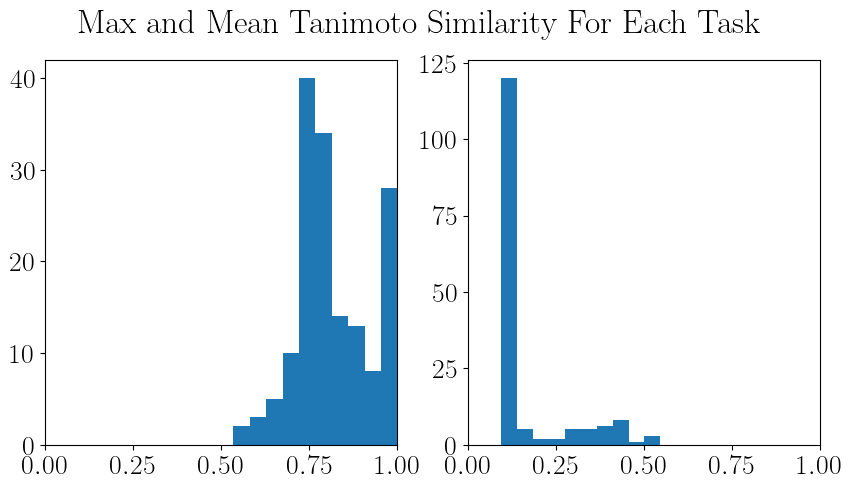

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Max and Mean Tanimoto Similarity For Each Task')
ax1.hist([sims_task.max() for sims_task in sims_tasks])
ax2.hist([sims_task.mean() for sims_task in sims_tasks])

ax1.set_xlim(0, 1)
ax2.set_xlim(0, 1)

plt.show()

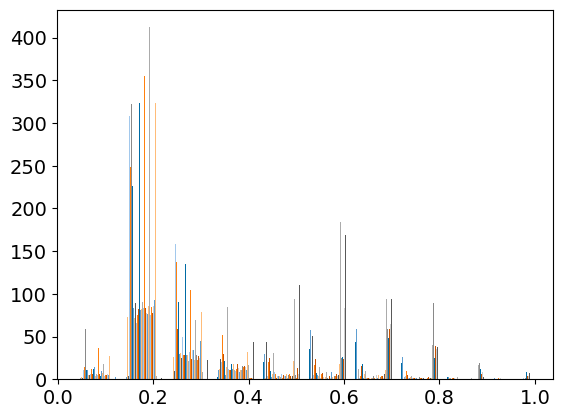

In [21]:
plt.hist([sims_task.max(axis=0) for sims_task in sims_tasks])
plt.show()

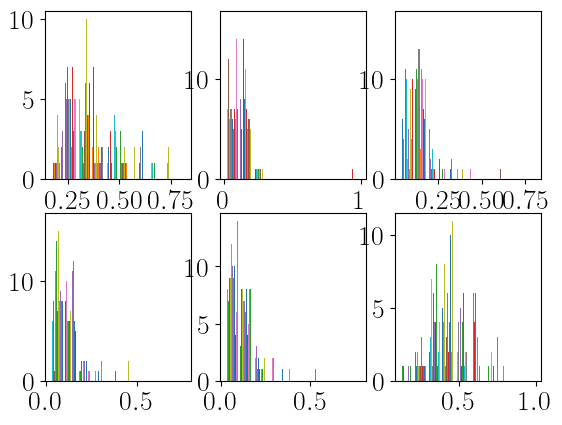

In [25]:
fig, ax = plt.subplots(2, 3)
ax[0][0].hist(sims_tasks[0])
ax[0][1].hist(sims_tasks[25])
ax[0][2].hist(sims_tasks[50])
ax[1][0].hist(sims_tasks[100])
ax[1][1].hist(sims_tasks[125])
ax[1][2].hist(sims_tasks[150])
plt.show()


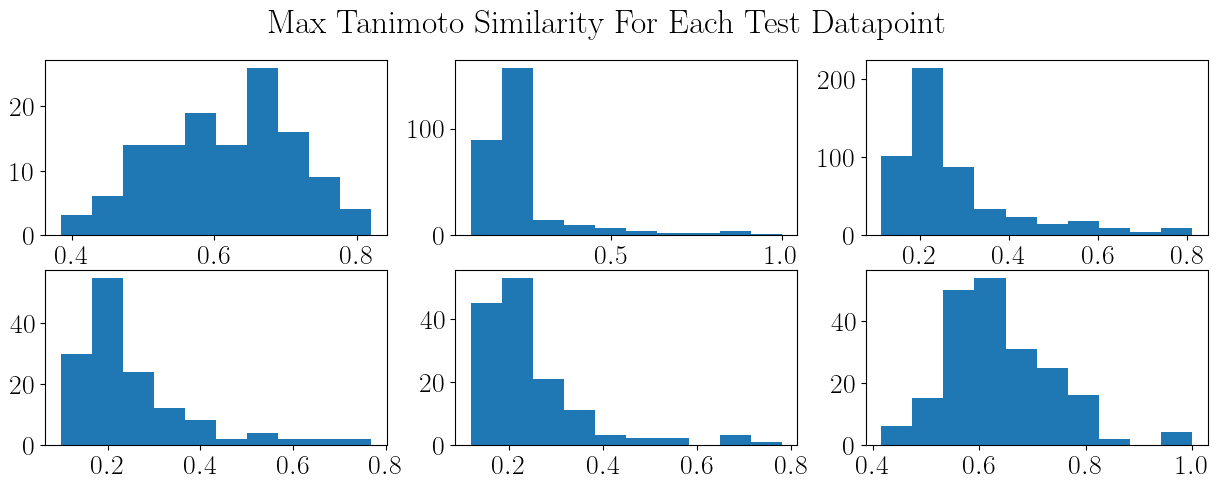

In [30]:
fig, ax = plt.subplots(2, 3, figsize=(15, 5))
fig.suptitle('Max Tanimoto Similarity For Each Test Datapoint')
ax[0][0].hist(sims_tasks[0].max(axis=0))
ax[0][1].hist(sims_tasks[25].max(axis=0))
ax[0][2].hist(sims_tasks[50].max(axis=0))
ax[1][0].hist(sims_tasks[100].max(axis=0))
ax[1][1].hist(sims_tasks[125].max(axis=0))
ax[1][2].hist(sims_tasks[150].max(axis=0))
plt.show()

In [31]:
thr = 0.5
similar_ind: List[np.ndarray] = [sims_task.max(axis=0) >= thr for sims_task in sims_tasks]
not_similar_ind: List[np.ndarray] = [np.logical_not(ind) for ind in similar_ind]
""" th1 = 0.4
th2 = 0.6
not_similar_ind = sims.max(axis=0) < th1
similar_ind = (sims.max(axis=0) >= th1) & (sims.max(axis=0) < th2)
very_similar_ind = sims.max(axis=0) >= th2 """

' th1 = 0.4\nth2 = 0.6\nnot_similar_ind = sims.max(axis=0) < th1\nsimilar_ind = (sims.max(axis=0) >= th1) & (sims.max(axis=0) < th2)\nvery_similar_ind = sims.max(axis=0) >= th2 '

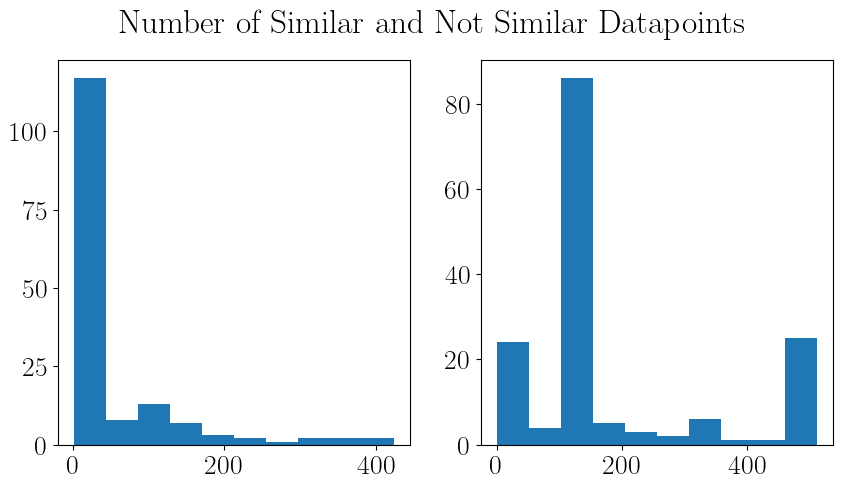

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Number of Similar and Not Similar Datapoints')
ax1.hist([ind.sum() for ind in similar_ind])
ax2.hist([ind.sum() for ind in not_similar_ind])
#ax2.hist([sim_ind.size - sim_ind.sum() for sim_ind in similar_ind])

plt.show()

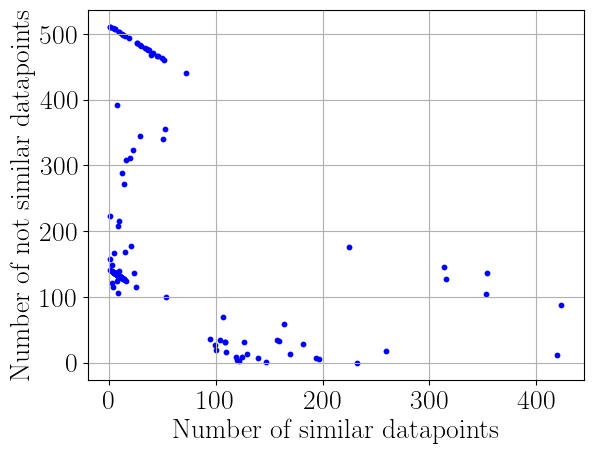

In [37]:
a = [ind.sum() for ind in similar_ind]
b = [ind.sum() for ind in not_similar_ind]
plt.scatter(a, b, s=10, c='b')
plt.xlabel('Number of similar datapoints')
plt.ylabel('Number of not similar datapoints')
plt.grid()

In [31]:
len(similar_ind)

157

In [48]:
from itertools import compress
a = list(compress(tasks_sample[0].test_samples, similar_ind[0]))

In [51]:
vars(a[0])

{'task_name': 'CHEMBL1066254',
 'smiles': 'CC(C)N(CCC(=O)c1ccccn1)Cc1ccccc1',
 'graph': GraphData(node_features=array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
       

In [ ]:
import jsonlines
output_path = os.path.join("/data/local/apps/", "Meta-Learning", "FS-Mol", "output.jsonl")
b = [vars(mol) for mol in a]
with jsonlines.open(output_path, mode='w') as writer:
    writer.write(b)

In [3]:
## Reading informations about targets
import pandas as pd
import os
train_proteins = pd.read_csv(os.path.join(FS_MOL_DATASET_PATH, "targets", "train_proteins.csv"))


In [5]:
from collections import Counter
Counter(train_proteins.confidence)

Counter({4: 125, 5: 139, 6: 82, 7: 184, 8: 1347, 9: 3061})

In [14]:
embedding_path = os.path.join(FS_MOL_DATASET_PATH, 'embeddings')
feature_files = os.listdir(embedding_path)

In [15]:
embedding_files = [os.path.join(embedding_path, file) for file in feature_files]

In [39]:
for i, files in tqdm(enumerate(embedding_files)):
    with open(files, 'rb') as f:
        data = pickle.load(f)
    assert isinstance(list(data.values())[0]['smiles'], np.ndarray)
    assert isinstance(list(data.values())[0]['labels'], torch.Tensor)
    #feat = feature_files[i].split('.')[0]
    #assert isinstance(list(data.values())[0][feat], torch.Tensor)


36it [02:01,  3.39s/it]


In [20]:
with open(embedding_files[0], 'rb') as f:
    data = pickle.load(f)

In [36]:
list(data.values())[0]['smiles']

array(['N[C@H](CNc1nnc(-c2ccc3cnccc3c2)s1)Cc1ccc(C(F)(F)F)cc1',
       'N[C@H](CNc1nnc(-c2ccc3[nH]c(O)cc3c2)s1)Cc1ccc(C(F)(F)F)cc1',
       'N[C@H](CNC(=O)c1ccc2cnccc2c1)Cc1ccc(C(F)(F)F)cc1',
       'O=C(NC(c1ccccc1)C1CCNCC1)c1ccc2cnccc2c1',
       'O=C(NC(c1ccc2ccccc2c1)C1CCNCC1)c1ccc2cnccc2c1',
       'O=C(NC(c1nccs1)C1CCNCC1)c1ccc2cnccc2c1',
       'COc1ccc(C(NC(=O)c2ccc3cnccc3c2)C2CCNCC2)cc1F',
       'O=C(NC(c1ccc(F)c(F)c1)C1CCNCC1)c1ccc2cnccc2c1',
       'O=C(NC(c1ccc(Cl)c(-c2ccccc2)c1)C1CCNCC1)c1ccc2cnccc2c1',
       'N#Cc1cc(C(NC(=O)c2ccc3cnccc3c2)C2CCNCC2)ccc1Cl',
       'O=C(NC(c1cccc(Cl)c1)C1CCNCC1)c1ccc2cnccc2c1',
       'O=C(NC(c1ccc(Cl)cc1)C1CCNCC1)c1ccc2cnccc2c1',
       'O=C(NC(c1ccc(Cl)c(F)c1)C1CCNCC1)c1ccc2cnccc2c1',
       'O=C(NC(c1cccc(Cl)c1Cl)C1CCNCC1)c1ccc2cnccc2c1',
       'O=C(NC(c1ccc(Cl)c(Cl)c1)C1CCNCC1)c1ccc2cnccc2c1',
       'O=C(NC(c1cnc(Cl)c(Cl)c1)C1CCNCC1)c1ccc2cnccc2c1',
       'O=C(NC(c1ccc(Cl)c(Cl)c1)C1CCNCC1)c1ccc2[nH]c(O)cc2c1',
       'O=C(NC(c1ccc

In [57]:
ls datasets/train/hardness_intra/

knn_16.pkl  perc_scaffolds.pkl  rf_16.pkl  rf_32.pkl


In [73]:
with open('datasets/test/hardness_intra/.pkl', 'rb') as f:
    data = pickle.load(f)


In [74]:
data['CHEMBL927977']

[FSMolTaskSampleEvalResults(size=3, acc=1.0, balanced_acc=1.0, f1=1.0, prec=1.0, recall=1.0, roc_auc=1.0, avg_precision=1.0, kappa=1.0, task_name='CHEMBL927977', seed=0, num_train=32, num_test=3, fraction_pos_train=0.5, fraction_pos_test=0.3333333333333333)]

In [75]:
results={}
for key, value in data.items():
    results[key] = {}
    results[key]['size'] = value[0].size
    results[key]['acc'] = value[0].acc
    results[key]['balanced_acc'] = value[0].balanced_acc
    results[key]['f1'] = value[0].f1
    results[key]['prec'] = value[0].prec
    results[key]['recall'] = value[0].recall
    results[key]['roc_auc'] = value[0].roc_auc
    results[key]['avg_precision'] = value[0].avg_precision
    results[key]['kappa'] = value[0].kappa
    results[key]['task_name'] = value[0].task_name
    results[key]['seed'] = value[0].seed
    results[key]['num}_train'] = value[0].num_train
    results[key]['num_test'] = value[0].num_test
    results[key]['fraction_pos_train'] = value[0].fraction_pos_train
    results[key]['fraction_pos_test'] = value[0].fraction_pos_test

IndexError: list index out of range

In [67]:
with open('../datasets/int_chem/test/rf_16.pkl', 'wb') as f:
    pickle.dump(results, f)

In [52]:
import pickle 
import torch
method="otdd_Roberta-Zinc480M-102M"
with open(f'../datasets/test/hardness/{method}.pkl', 'rb') as f:
    data = pickle.load(f)

In [53]:
data.keys()

dict_keys(['train_chembl_ids', 'test_chembl_ids', 'distance_matrices'])

In [54]:
distance_matrix = torch.stack(data['distance_matrices'])

In [55]:
my_dict={}
my_dict['train_chembl_ids'] = data['train_chembl_ids']
my_dict['test_chembl_ids'] = data['test_chembl_ids']
my_dict['distance_matrices'] = distance_matrix

In [56]:
my_dict['distance_matrices']

tensor([[114.7003, 165.8341,  98.7225,  ..., 159.1090, 128.5507, 101.1729],
        [131.1016, 123.5984,  97.9069,  ..., 125.9639, 106.7073,  73.7665],
        [123.4920, 104.1152,  87.5447,  ..., 136.1776,  19.0931,  99.7105],
        ...,
        [126.5093, 116.8636,  80.1325,  ..., 138.8273,  83.2828,  78.1273],
        [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
        [113.8114,  96.5568,  92.7921,  ..., 126.2726,  78.3781,  80.3184]])

In [57]:
with open(f'../../fsmol_hardness/ext_chem/{method}.pkl', 'wb') as f:
    pickle.dump(my_dict, f)

In [7]:
from fs_mol.data.fsmol_task_sampler import ScaffoldTaskSampler

In [8]:
s = ScaffoldTaskSampler(16, 0, None, True)

In [33]:
task = tasks[0]
samples = task.samples
num_samples = len(samples)
task_smiles =  [sample.smiles for sample in samples]

In [34]:
from splito import ScaffoldSplit

In [35]:
len(task_smiles)

157

In [36]:
train_test_splitter_obj = ScaffoldSplit(
            task_smiles, n_jobs=-1, n_splits=1, train_size=16, test_size=125, random_state=0
)

In [ ]:
train_valid_idxs, test_idxs = next(train_test_splitter_obj.split(X=np.array(task_smiles)))

In [21]:
import datamol as dm
def get_scaffold(mol, make_generic: bool = False):
    """
    Computes the Bemis-Murcko scaffold of a compound.
    If make_generic is True, the scaffold is made generic by replacing all side chains with R groups.
    """
    mol = dm.to_mol(mol)
    scaffold = dm.to_scaffold_murcko(mol, make_generic=make_generic)
    scaffold = dm.to_smiles(scaffold)
    return scaffold

In [23]:
from functools import partial
fn = partial(get_scaffold, make_generic=False)
scaffolds = dm.utils.parallelized(fn, task_smiles, n_jobs=-1, progress=True)

  0%|          | 0/157 [00:00<?, ?it/s]

In [25]:
np.unique(scaffolds).shape

(130,)

In [43]:
unique_scaffolds = []
task_size = []
for task in tasks:
    samples = task.samples
    num_samples = len(samples)
    task_size.append(num_samples)
    task_smiles =  [sample.smiles for sample in samples]
    scaffolds = dm.utils.parallelized(fn, task_smiles, n_jobs=-1, progress=False)
    unique_scaffolds.append(np.unique(scaffolds).shape[0])

    print(task.name)
    print(np.unique(scaffolds).shape[0] / num_samples)



CHEMBL1066254
0.16312056737588654
CHEMBL1006005
0.8181818181818182
CHEMBL1613926
0.43703703703703706
CHEMBL1243970
0.3894230769230769
CHEMBL1613898
0.9041916167664671
CHEMBL1613907
0.2080536912751678
CHEMBL1243967
0.3894230769230769
CHEMBL1614503
0.9402985074626866
CHEMBL1613949
0.930379746835443
CHEMBL1794504
0.8615384615384616
CHEMBL1738362
0.8561151079136691
CHEMBL1614508
0.5680473372781065
CHEMBL1738633
0.891156462585034
CHEMBL1738395
0.7371428571428571
CHEMBL1794519
0.8141025641025641
CHEMBL1737951
0.29015544041450775
CHEMBL1963824
0.6879432624113475
CHEMBL2219026
0.8280254777070064
CHEMBL1738485
0.7516556291390728
CHEMBL1963838
0.8833333333333333
CHEMBL1119333
0.5371702637889688
CHEMBL1963910
0.885
CHEMBL2218946
0.8280254777070064
CHEMBL1614466
0.8057040998217468
CHEMBL2218957
0.8280254777070064
CHEMBL2219043
0.8280254777070064
CHEMBL1963825
0.6798029556650246
CHEMBL2218959
0.8280254777070064
CHEMBL1738579
0.7336448598130841
CHEMBL1963731
0.559375
CHEMBL1963705
0.6049204052098408

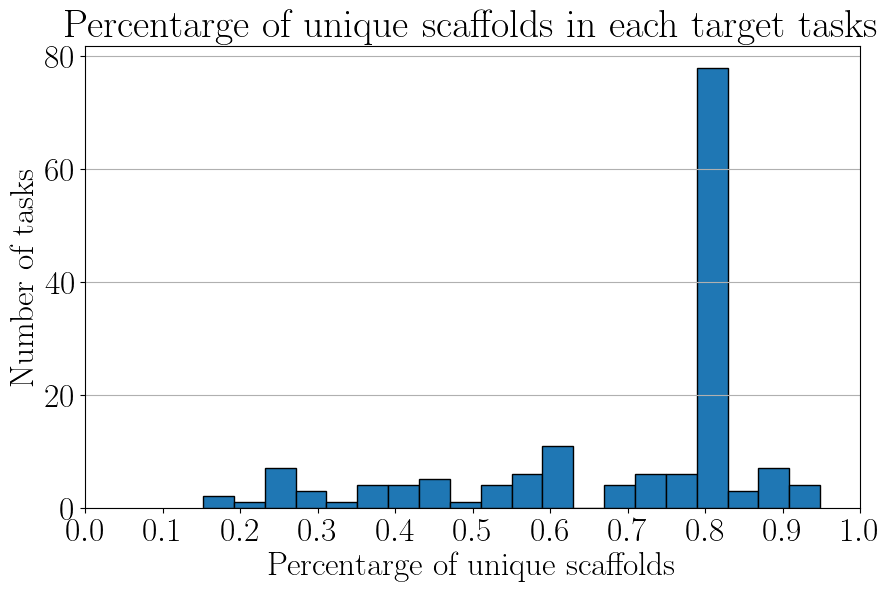

In [52]:
fig = plt.figure(figsize=(10, 6))
b= np.array(unique_scaffolds)/np.array(task_size)
plt.hist(b, bins=20, edgecolor='black')
plt.title('Percentarge of unique scaffolds in each target tasks')
plt.xlabel('Percentarge of unique scaffolds')
plt.ylabel('Number of tasks')
plt.grid(axis='y')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()

In [32]:
unique_scaffolds

[23,
 112,
 153,
 119,
 126,
 59,
 131,
 31,
 127,
 147,
 96,
 151,
 129,
 56,
 275,
 81,
 157,
 213,
 227,
 288,
 177,
 130,
 426,
 452,
 130,
 130,
 468,
 358,
 375,
 81,
 276,
 130,
 130,
 376,
 212,
 130,
 391,
 224,
 243,
 130,
 130,
 531,
 130,
 130,
 130,
 450,
 291,
 130,
 418,
 130,
 130,
 252,
 256,
 480,
 212,
 130,
 556,
 532,
 558,
 1644,
 130,
 630,
 130,
 1105,
 130,
 130,
 130,
 130,
 271,
 130,
 130,
 1602,
 145,
 130,
 130,
 130,
 436,
 130,
 130,
 130,
 1919,
 130,
 130,
 130,
 574,
 130,
 130,
 130,
 130,
 130,
 1400,
 130,
 130,
 130,
 321,
 130,
 130,
 1259,
 130,
 130,
 130,
 130,
 130,
 165,
 130,
 130,
 130,
 56,
 89,
 130,
 130,
 130,
 130,
 130,
 254,
 203,
 130,
 130,
 209,
 130,
 2443,
 130,
 130,
 71,
 439,
 211,
 130,
 130,
 130,
 130,
 105,
 42,
 70,
 130,
 130,
 24,
 130,
 130,
 118,
 130,
 128,
 130,
 136,
 60,
 39,
 33,
 68,
 130,
 33,
 69,
 60,
 57,
 130,
 50,
 211,
 68,
 130]

In [137]:
chemical_distance_path = os.path.join(FS_MOL_DATASET_PATH, 'test', 'hardness', 'otdd_gin_supervised_infomax.pkl')
with open(chemical_distance_path, 'rb') as f:
    data = pickle.load(f)

protein_distance_path = os.path.join(FS_MOL_DATASET_PATH, 'targets', 'esm2_output', 'esm2_t33_650M_UR50D', 'protein_distance_matrix.pkl')
with open(protein_distance_path, 'rb') as f:
    metadata = pickle.load(f)   

In [133]:
metadata_distance= metadata['distance_matrices']

In [134]:
data_distance = torch.stack(data['distance_matrices'], dim=0)

In [140]:
import pandas as pd
metadata_df = pd.DataFrame(metadata_distance)
metadata_df.columns = metadata['test_chembl_ids']
metadata_df.index = metadata['train_chembl_ids']

data_df = pd.DataFrame(data_distance)
data_df.columns = data['test_chembl_ids']
data_df.index = data['train_chembl_ids']

In [146]:
metadata_df = metadata_df.reindex(data_df.index)
metadata_df = metadata_df[data_df.columns]

In [151]:
(data_df.index == metadata_df.index).all()
(data_df.columns == metadata_df.columns).all()

True

In [164]:
normalized_data_df=(data_df-data_df.min(axis=0))/(data_df.max(axis=0)-data_df.min(axis=0))
normalized_metadata_df=(metadata_df-metadata_df.min(axis=0))/(metadata_df.max(axis=0)-metadata_df.min(axis=0))

In [ ]:
print(normalized_data_df.max())
print(normalized_metadata_df.max())

print(normalized_data_df.min())
print(normalized_metadata_df.min())

In [176]:
normalized_data_df

,CHEMBL1066254,CHEMBL1006005,CHEMBL1243970,CHEMBL1613907,CHEMBL1963825,CHEMBL1613898,CHEMBL1613949,CHEMBL1737951,CHEMBL1738362,CHEMBL1614503,...,CHEMBL1613777,CHEMBL4005586,CHEMBL3705334,CHEMBL3887333,CHEMBL924949,CHEMBL915809,CHEMBL3887759,CHEMBL819742,CHEMBL2219270,CHEMBL3431930
CHEMBL1825378,0.176086,0.164603,0.193642,0.177783,0.200987,0.089349,0.101275,NaN,0.087746,0.097882,...,0.103181,0.088367,0.104936,0.081999,0.090158,0.190642,0.196942,0.139965,0.233839,0.106448
CHEMBL2186145,0.162269,0.125991,0.134917,0.141336,0.162481,0.042504,0.042779,NaN,0.039269,0.043416,...,0.072591,0.075047,0.059808,0.032204,0.057594,0.159910,0.165592,0.079838,0.198790,0.045832
CHEMBL2219001,0.241441,0.177127,0.222103,0.235910,0.188779,0.098919,0.117104,NaN,0.118428,0.090980,...,0.107181,0.163179,0.200530,0.161379,0.170867,0.254208,0.275198,0.194429,0.005791,0.156184
CHEMBL1614055,0.328833,0.304597,0.351519,0.357860,0.342828,0.241965,0.232963,NaN,0.247052,0.188247,...,0.262395,0.288882,0.343764,0.294528,0.323380,0.381275,0.401637,0.320267,0.350767,0.298597
CHEMBL763437,0.157436,0.113120,0.130727,0.129608,0.152523,0.021321,0.026672,NaN,0.031911,0.025717,...,0.050866,0.031020,0.060094,0.034582,0.045791,0.147684,0.161496,0.060609,0.179061,0.024497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL2218966,0.241363,0.177388,0.222149,0.235934,0.189518,0.098998,0.117671,NaN,0.118550,0.091383,...,0.111186,0.163247,0.200489,0.161515,0.171024,0.254164,0.275217,0.194560,0.009680,0.156187
CHEMBL1794452,0.171611,0.118424,0.187513,0.175258,0.175182,0.041425,0.047707,NaN,0.047088,0.038768,...,0.058634,0.089569,0.119920,0.080696,0.095970,0.178578,0.198588,0.122593,0.198726,0.086025
CHEMBL1062867,0.225317,0.155235,0.196289,0.207233,0.161500,0.094829,0.102070,NaN,0.101868,0.096267,...,0.107132,0.128396,0.170175,0.121577,0.137355,0.223019,0.247099,0.163258,0.173249,0.120941
CHEMBL3880346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [180]:
df = normalized_data_df.add(normalized_metadata_df)
df.dropna(axis=1, how='all', inplace=True)

In [187]:
df

,CHEMBL1066254,CHEMBL1006005,CHEMBL1243970,CHEMBL1613907,CHEMBL1963825,CHEMBL1613898,CHEMBL1613949,CHEMBL1738362,CHEMBL1614503,CHEMBL1119333,...,CHEMBL1613777,CHEMBL4005586,CHEMBL3705334,CHEMBL3887333,CHEMBL924949,CHEMBL915809,CHEMBL3887759,CHEMBL819742,CHEMBL2219270,CHEMBL3431930
CHEMBL1825378,0.741576,0.663077,0.839415,0.653495,0.632753,0.661808,0.530479,0.378529,0.612313,0.649975,...,0.446508,0.577986,0.621756,0.643491,0.634787,0.744074,0.765574,0.588224,0.669187,0.569977
CHEMBL2186145,0.291668,0.317787,0.385829,0.345650,0.369730,0.313382,0.194855,0.520139,0.243776,0.391635,...,0.631879,0.198597,0.191727,0.120021,0.245104,0.398833,0.379829,0.247691,0.385009,0.073879
CHEMBL2219001,0.881968,0.769441,0.926345,0.815919,0.712378,0.728648,0.653475,0.463228,0.695448,0.771311,...,0.507291,0.736102,0.793605,0.788356,0.793175,0.889117,0.914533,0.741174,0.539005,0.700908
CHEMBL1614055,0.624576,0.650274,0.596619,0.751984,0.728648,0.402628,0.474372,0.770424,0.476615,0.633552,...,0.889209,0.496965,0.508735,0.493943,0.647487,0.728559,0.654886,0.628599,0.635530,0.457009
CHEMBL763437,0.332853,0.350205,0.330839,0.464175,0.383600,0.179350,0.097162,0.554338,0.205910,0.331191,...,0.632820,0.152428,0.118249,0.148076,0.276989,0.413674,0.236312,0.272149,0.355746,0.111153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL2218966,0.473355,0.404512,0.495720,0.513516,0.380181,0.250207,0.169201,0.540981,0.289391,0.438947,...,0.609979,0.237362,0.281579,0.332608,0.428089,0.541040,0.438703,0.393315,0.100503,0.220802
CHEMBL1794452,0.929985,0.829960,0.977189,0.905979,0.869076,0.775780,0.686128,0.464644,0.772368,0.762110,...,0.500045,0.795883,0.801506,0.837301,0.846877,0.930471,0.924267,0.793415,0.883775,0.783092
CHEMBL1062867,0.418501,0.319575,0.456726,0.461791,0.307841,0.280800,0.212423,0.578247,0.242763,0.466420,...,0.595858,0.254762,0.272530,0.263462,0.352230,0.468966,0.435256,0.375530,0.254271,0.208351
CHEMBL3880346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [198]:
nearest=[]
task_list={}
K=500
for col in df.columns:
    a = df.sort_values(by=col,axis=0)
    nearest.append(a.index[0:K].tolist())
    task_list[col] = a.index[0:K].to_list()


In [199]:
df

,CHEMBL1066254,CHEMBL1006005,CHEMBL1243970,CHEMBL1613907,CHEMBL1963825,CHEMBL1613898,CHEMBL1613949,CHEMBL1738362,CHEMBL1614503,CHEMBL1119333,...,CHEMBL1613777,CHEMBL4005586,CHEMBL3705334,CHEMBL3887333,CHEMBL924949,CHEMBL915809,CHEMBL3887759,CHEMBL819742,CHEMBL2219270,CHEMBL3431930
CHEMBL1825378,0.741576,0.663077,0.839415,0.653495,0.632753,0.661808,0.530479,0.378529,0.612313,0.649975,...,0.446508,0.577986,0.621756,0.643491,0.634787,0.744074,0.765574,0.588224,0.669187,0.569977
CHEMBL2186145,0.291668,0.317787,0.385829,0.345650,0.369730,0.313382,0.194855,0.520139,0.243776,0.391635,...,0.631879,0.198597,0.191727,0.120021,0.245104,0.398833,0.379829,0.247691,0.385009,0.073879
CHEMBL2219001,0.881968,0.769441,0.926345,0.815919,0.712378,0.728648,0.653475,0.463228,0.695448,0.771311,...,0.507291,0.736102,0.793605,0.788356,0.793175,0.889117,0.914533,0.741174,0.539005,0.700908
CHEMBL1614055,0.624576,0.650274,0.596619,0.751984,0.728648,0.402628,0.474372,0.770424,0.476615,0.633552,...,0.889209,0.496965,0.508735,0.493943,0.647487,0.728559,0.654886,0.628599,0.635530,0.457009
CHEMBL763437,0.332853,0.350205,0.330839,0.464175,0.383600,0.179350,0.097162,0.554338,0.205910,0.331191,...,0.632820,0.152428,0.118249,0.148076,0.276989,0.413674,0.236312,0.272149,0.355746,0.111153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL2218966,0.473355,0.404512,0.495720,0.513516,0.380181,0.250207,0.169201,0.540981,0.289391,0.438947,...,0.609979,0.237362,0.281579,0.332608,0.428089,0.541040,0.438703,0.393315,0.100503,0.220802
CHEMBL1794452,0.929985,0.829960,0.977189,0.905979,0.869076,0.775780,0.686128,0.464644,0.772368,0.762110,...,0.500045,0.795883,0.801506,0.837301,0.846877,0.930471,0.924267,0.793415,0.883775,0.783092
CHEMBL1062867,0.418501,0.319575,0.456726,0.461791,0.307841,0.280800,0.212423,0.578247,0.242763,0.466420,...,0.595858,0.254762,0.272530,0.263462,0.352230,0.468966,0.435256,0.375530,0.254271,0.208351
CHEMBL3880346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [202]:
df.sort_values(by ='CHEMBL1006005', axis=0) 

,CHEMBL1066254,CHEMBL1006005,CHEMBL1243970,CHEMBL1613907,CHEMBL1963825,CHEMBL1613898,CHEMBL1613949,CHEMBL1738362,CHEMBL1614503,CHEMBL1119333,...,CHEMBL1613777,CHEMBL4005586,CHEMBL3705334,CHEMBL3887333,CHEMBL924949,CHEMBL915809,CHEMBL3887759,CHEMBL819742,CHEMBL2219270,CHEMBL3431930
CHEMBL1006149,0.331579,0.121033,0.408035,0.381621,0.357900,0.326128,0.177849,0.534908,0.233470,0.402040,...,0.562064,0.223200,0.226541,0.208555,0.255822,0.382789,0.389601,0.243851,0.392732,0.107016
CHEMBL2169429,0.440058,0.123940,0.542523,0.496084,0.421228,0.402124,0.282532,0.587083,0.308640,0.482268,...,0.560113,0.365093,0.366244,0.336754,0.367863,0.469899,0.516068,0.359593,0.460001,0.257897
CHEMBL4009583,0.341174,0.148346,0.393749,0.379410,0.351957,0.311402,0.169535,0.518280,0.219304,0.397723,...,0.556213,0.178883,0.223638,0.200700,0.274089,0.393482,0.391420,0.265831,0.372956,0.102698
CHEMBL976298,0.336902,0.164268,0.456241,0.439105,0.389265,0.343446,0.203057,0.555715,0.248417,0.437762,...,0.598323,0.259018,0.295185,0.255798,0.327490,0.436684,0.441299,0.289309,0.413967,0.148787
CHEMBL4146144,0.390060,0.182385,0.468140,0.435304,0.393851,0.356359,0.224471,0.570083,0.266116,0.434136,...,0.607530,0.251113,0.304973,0.256978,0.345562,0.448728,0.432406,0.332446,0.416718,0.162732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL1738377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHEMBL871626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHEMBL3887069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHEMBL2212769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [203]:
task_list['CHEMBL1006005']

['CHEMBL1006149',
 'CHEMBL2169429',
 'CHEMBL4009583',
 'CHEMBL976298',
 'CHEMBL4146144',
 'CHEMBL2449559',
 'CHEMBL974470',
 'CHEMBL914418',
 'CHEMBL1014292',
 'CHEMBL3039488',
 'CHEMBL3039491',
 'CHEMBL3214784',
 'CHEMBL3418219',
 'CHEMBL658514',
 'CHEMBL1948105',
 'CHEMBL4027820',
 'CHEMBL754111',
 'CHEMBL751606',
 'CHEMBL924958',
 'CHEMBL658515',
 'CHEMBL4027821',
 'CHEMBL3418221',
 'CHEMBL3239460',
 'CHEMBL1286959',
 'CHEMBL656201',
 'CHEMBL1103506',
 'CHEMBL1936453',
 'CHEMBL3615230',
 'CHEMBL3419982',
 'CHEMBL3039492',
 'CHEMBL2339990',
 'CHEMBL3039493',
 'CHEMBL4018050',
 'CHEMBL3705827',
 'CHEMBL1827948',
 'CHEMBL859181',
 'CHEMBL710727',
 'CHEMBL3039489',
 'CHEMBL839592',
 'CHEMBL748035',
 'CHEMBL945284',
 'CHEMBL974340',
 'CHEMBL1243605',
 'CHEMBL932102',
 'CHEMBL751028',
 'CHEMBL1918197',
 'CHEMBL882607',
 'CHEMBL1113982',
 'CHEMBL2427205',
 'CHEMBL1002945',
 'CHEMBL710566',
 'CHEMBL830370',
 'CHEMBL967900',
 'CHEMBL999422',
 'CHEMBL713449',
 'CHEMBL2026780',
 'CHEMBL2405916

In [206]:
pd.DataFrame(task_list).to_csv('datasets/nearest_tasks.csv')

In [97]:
data_sorted, data_indices = torch.sort(data_distance, dim=0)
metadata_sorted, metadata_indices = torch.sort(metadata_distance, dim=0)

In [102]:
metadata_sorted[:20,0]

tensor([0.2681, 0.2681, 0.2681, 0.2681, 0.2681, 0.9490, 1.2438, 1.2438, 1.2438,
        1.2607, 1.2607, 1.2607, 1.2607, 1.2607, 1.2607, 1.2607, 1.2607, 1.2607,
        1.2922, 1.2922])

In [101]:
data_sorted[:20,0]

tensor([6.0115, 6.3363, 7.3419, 7.3446, 7.6152, 7.7023, 7.8060, 7.9092, 8.0059,
        8.0226, 8.0244, 8.0374, 8.0700, 8.0851, 8.0992, 8.1222, 8.1231, 8.1259,
        8.1383, 8.1446])

In [106]:
def normalize(x):
    x_normed = x / x.max(0, keepdim=True)[0]
    return x_normed

In [105]:
data_sorted.shape

torch.Size([4938, 157])

In [120]:
normalize(torch.nan_to_num(data_sorted, nan=0.0))

tensor([[0.2155, 0.1527, 0.0313,  ..., 0.1134, 0.0671, 0.1240],
        [0.2271, 0.1996, 0.0388,  ..., 0.1172, 0.0675, 0.1304],
        [0.2632, 0.2228, 0.0422,  ..., 0.1286, 0.0676, 0.1334],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [121]:
normalize(torch.nan_to_num(metadata_sorted, nan=0.0))

tensor([[0.0431, 0.1144, 0.2742,  ..., 0.1375, 0.1415, 0.0948],
        [0.0431, 0.1144, 0.2742,  ..., 0.1375, 0.1415, 0.0948],
        [0.0431, 0.1144, 0.2742,  ..., 0.1436, 0.1415, 0.0948],
        ...,
        [0.9880, 1.0000, 1.0000,  ..., 1.0000, 0.9811, 1.0000],
        [0.9880, 1.0000, 1.0000,  ..., 1.0000, 0.9811, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]])

In [29]:
import json
with open('datasets/fsmol-0.1.json', 'r') as f:
    fsmol_original_lookup = json.load(f)

nearest_df = pd.read_csv('datasets/nearest_tasks.csv', index_col=0)


In [31]:
for chembl in nearest_df.columns:
    task_lookup = {}
    task_lookup['train'] = nearest_df[chembl].to_list()
    task_lookup['valid'] = fsmol_original_lookup['valid']
    task_lookup['test'] = [chembl]
    with open(f'datasets/{chembl}_selection.json', 'w') as f:
        json.dump(task_lookup, f)


In [32]:
import random
K = 500
for chembl in nearest_df.columns:
    task_lookup = {}
    task_lookup['train'] = random.sample(fsmol_original_lookup['train'], K)
    task_lookup['valid'] = fsmol_original_lookup['valid']
    task_lookup['test'] = [chembl]
    with open(f'datasets/{chembl}_random.json', 'w') as f:
        json.dump(task_lookup, f)

In [35]:
import json
import glob
for file in glob.glob('datasets/*_random.json'):
    with open(f'{file}', 'r') as f:
        data = json.load(f)
        assert data['train'].__len__() == 500
        assert data['valid'].__len__() == 40
        assert data['test'].__len__() == 1


In [3]:
import glob
list_of_files = glob.glob('outputs/FSMol_ProtoNet_gnn+ecfp+fc*')

In [5]:
for files in list_of_files:
    print(files)
    task_name = '_'.join(files.split('_')[3:5])
    pretrained_model = os.path.join(FS_MOL_CHECKOUT_PATH, files, "best_validation.pt")
    task_list_file = os.path.join(FS_MOL_DATASET_PATH, "done", task_name)
    dataset_path= FS_MOL_DATASET_PATH
    ! python fs_mol/protonet_test.py {pretrained_model} {dataset_path} --task-list-file {task_list_file} 

outputs/FSMol_ProtoNet_gnn+ecfp+fc_CHEMBL4005586_random.json_2024-03-16_11-51-10
2024-03-19 11:41:35: Identified 500 training tasks.
2024-03-19 11:41:35: Identified 40 validation tasks.
2024-03-19 11:41:35: Identified 1 test tasks.
2024-03-19 11:41:35: Starting test run FSMol_Eval_ProtoNet_CHEMBL4005586_random_2024-03-19_11-41-30 on 1 assays
2024-03-19 11:41:35: 	Arguments: Namespace(TRAINED_MODEL='/data/local/apps/Meta-Learning/FS-Mol/outputs/FSMol_ProtoNet_gnn+ecfp+fc_CHEMBL4005586_random.json_2024-03-16_11-51-10/best_validation.pt', DATA_PATH=['/data/local/apps/Meta-Learning/FS-Mol/datasets'], task_list_file='/data/local/apps/Meta-Learning/FS-Mol/datasets/done/CHEMBL4005586_random.json', save_dir='outputs', num_runs=10, seed=0, train_sizes=[16, 32, 64, 128, 256], test_size=None, batch_size=320, use_fresh_param_init=False)
2024-03-19 11:41:35: 	Output dir: outputs/FSMol_Eval_ProtoNet_CHEMBL4005586_random_2024-03-19_11-41-30
Device: cuda
2024-03-19 11:41:35: Using model weights loaded

In [4]:
for file in glob.glob('outputs/FSMol_Eval_ProtoNet_CHEMBL*'):
    evaluation_output_directory = os.path.join(FS_MOL_CHECKOUT_PATH, file)
    model_name = "ProtoNet"
    ! python fs_mol/plotting/collect_eval_runs.py {model_name} {evaluation_output_directory}

['outputs/FSMol_ProtoNet_gnn+ecfp+fc_CHEMBL4005586_random.json_2024-03-16_11-51-10',
 'outputs/FSMol_ProtoNet_gnn+ecfp+fc_CHEMBL2219335_selection.json_2024-03-14_03-07-10',
 'outputs/FSMol_ProtoNet_gnn+ecfp+fc_CHEMBL3705469_selection.json_2024-03-15_13-27-04',
 'outputs/FSMol_ProtoNet_gnn+ecfp+fc_CHEMBL1119333_random.json_2024-03-13_16-08-58',
 'outputs/FSMol_ProtoNet_gnn+ecfp+fc_CHEMBL3887334_selection.json_2024-03-16_05-35-16',
 'outputs/FSMol_ProtoNet_gnn+ecfp+fc_CHEMBL2219340_selection.json_2024-03-14_04-46-33',
 'outputs/FSMol_ProtoNet_gnn+ecfp+fc_CHEMBL2354305_random.json_2024-03-15_01-39-51',
 'outputs/FSMol_ProtoNet_gnn+ecfp+fc_CHEMBL2219404_random.json_2024-03-14_20-37-02',
 'outputs/FSMol_ProtoNet_gnn+ecfp+fc_CHEMBL2219334_random.json_2024-03-14_00-31-38',
 'outputs/FSMol_ProtoNet_gnn+ecfp+fc_CHEMBL3431930_random.json_2024-03-15_05-21-05',
 'outputs/FSMol_ProtoNet_gnn+ecfp+fc_CHEMBL2219389_selection.json_2024-03-14_18-12-09',
 'outputs/FSMol_ProtoNet_gnn+ecfp+fc_CHEMBL2219358

In [5]:
files = "FSMol_ProtoNet_gnn+ecfp+fc_CHEMBL2219363_selection.json_2024-03-14_13-11-20"
pretrained_model = os.path.join(FS_MOL_CHECKOUT_PATH, "outputs", files, "best_validation.pt")
task_list_file = os.path.join(FS_MOL_DATASET_PATH, "CHEMBL2219363_selection.json")
dataset_path= FS_MOL_DATASET_PATH
! python fs_mol/protonet_test.py {pretrained_model} {dataset_path} --task-list-file {task_list_file} 

2024-03-18 18:04:16: Identified 500 training tasks.
2024-03-18 18:04:16: Identified 40 validation tasks.
2024-03-18 18:04:16: Identified 1 test tasks.
2024-03-18 18:04:16: Starting test run FSMol_Eval_ProtoNet_CHEMBL2219363_selection_2024-03-18_18-04-12 on 1 assays
2024-03-18 18:04:16: 	Arguments: Namespace(TRAINED_MODEL='/data/local/apps/Meta-Learning/FS-Mol/outputs/FSMol_ProtoNet_gnn+ecfp+fc_CHEMBL2219363_selection.json_2024-03-14_13-11-20/best_validation.pt', DATA_PATH=['/data/local/apps/Meta-Learning/FS-Mol/datasets'], task_list_file='/data/local/apps/Meta-Learning/FS-Mol/datasets/CHEMBL2219363_selection.json', save_dir='outputs', num_runs=10, seed=0, train_sizes=[16, 32, 64, 128, 256], test_size=None, batch_size=320, use_fresh_param_init=False)
2024-03-18 18:04:16: 	Output dir: outputs/FSMol_Eval_ProtoNet_CHEMBL2219363_selection_2024-03-18_18-04-12
Device: cuda
2024-03-18 18:04:16: Using model weights loaded from /data/local/apps/Meta-Learning/FS-Mol/outputs/FSMol_ProtoNet_gnn+ecf